### Ejercicio 7: segunda parte
**Segunda propuesta de mejora:**

Reducir la distancia temporal minima permitida entre dos aterrizajes. En el problema original los aviones deben aterrizar con 4 minutos de diferencia minimamente, por seguridad y para dar tiempo a despegues. Proponemos reducir este tiempo a 2 minutos, la distancia temporal mínima permitida para aviones no hiper pesados (como los que llegan a AEP) segun [EEUU Federal Aviation Administration](https://www-faa-gov.translate.goog/air_traffic/publications/atpubs/atc_html/chap3_section_10.html?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=sge#:~:text=Category%20I%20aircraft%20landing%20behind,category%20III%20aircraft%2D%206%2C000%20feet.). 

Este tiempo respeta las medidas de seguruidad, pero no da lugar a despegues, lo cual debilita la robstez de la propuesta desde un principio. Sin embargo, con lamdas bajos esto puede no ser un problema, ya que es poco probable que lleguen 2 o más aviones muy segudos (o con menos de 4min de diferencia). Es decir, con lamdas bajos, permitir que dos aviones aterricen con minimamente 2 minutos de distancia temporal entre ellos puede reducir el tiempo de atraso promedio y no inteferir en gran medida con la programación de aterrizajes y despegues del aeropuerto ya que no es probable que pase muy seguido. 

Hipótesis: reducción del atraso promedio y de los desviós a Montevideo. 

Total aviones generados: 230
Aterrizados: 190


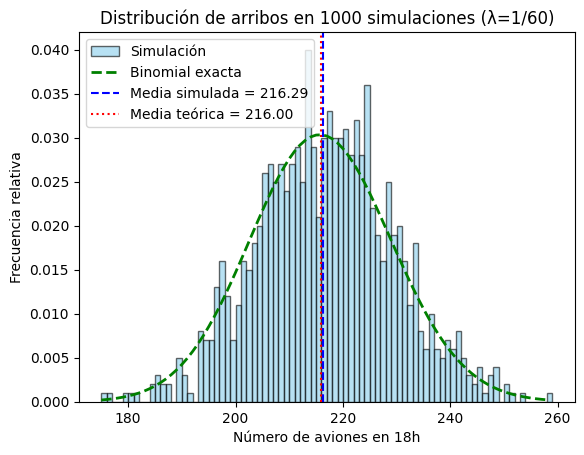

/var/folders/0y/tsllkfts05ngtc3fr0xjb6tm0000gn/T/ipykernel_15815/3146726970.py:229: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", len(ids))


===== 📊 Resumen de la simulación con lam= 0.2 =====
✈️ Total de aviones: 230
✅ Aterrizados: 190
❌ Desviados: 36
🕐 Activos al final: 4
Suma de minutos de atraso de todos los aviones aterrizados en la simulacion: 562.8000000000003
 Atraso promedio: 2.962105263157896


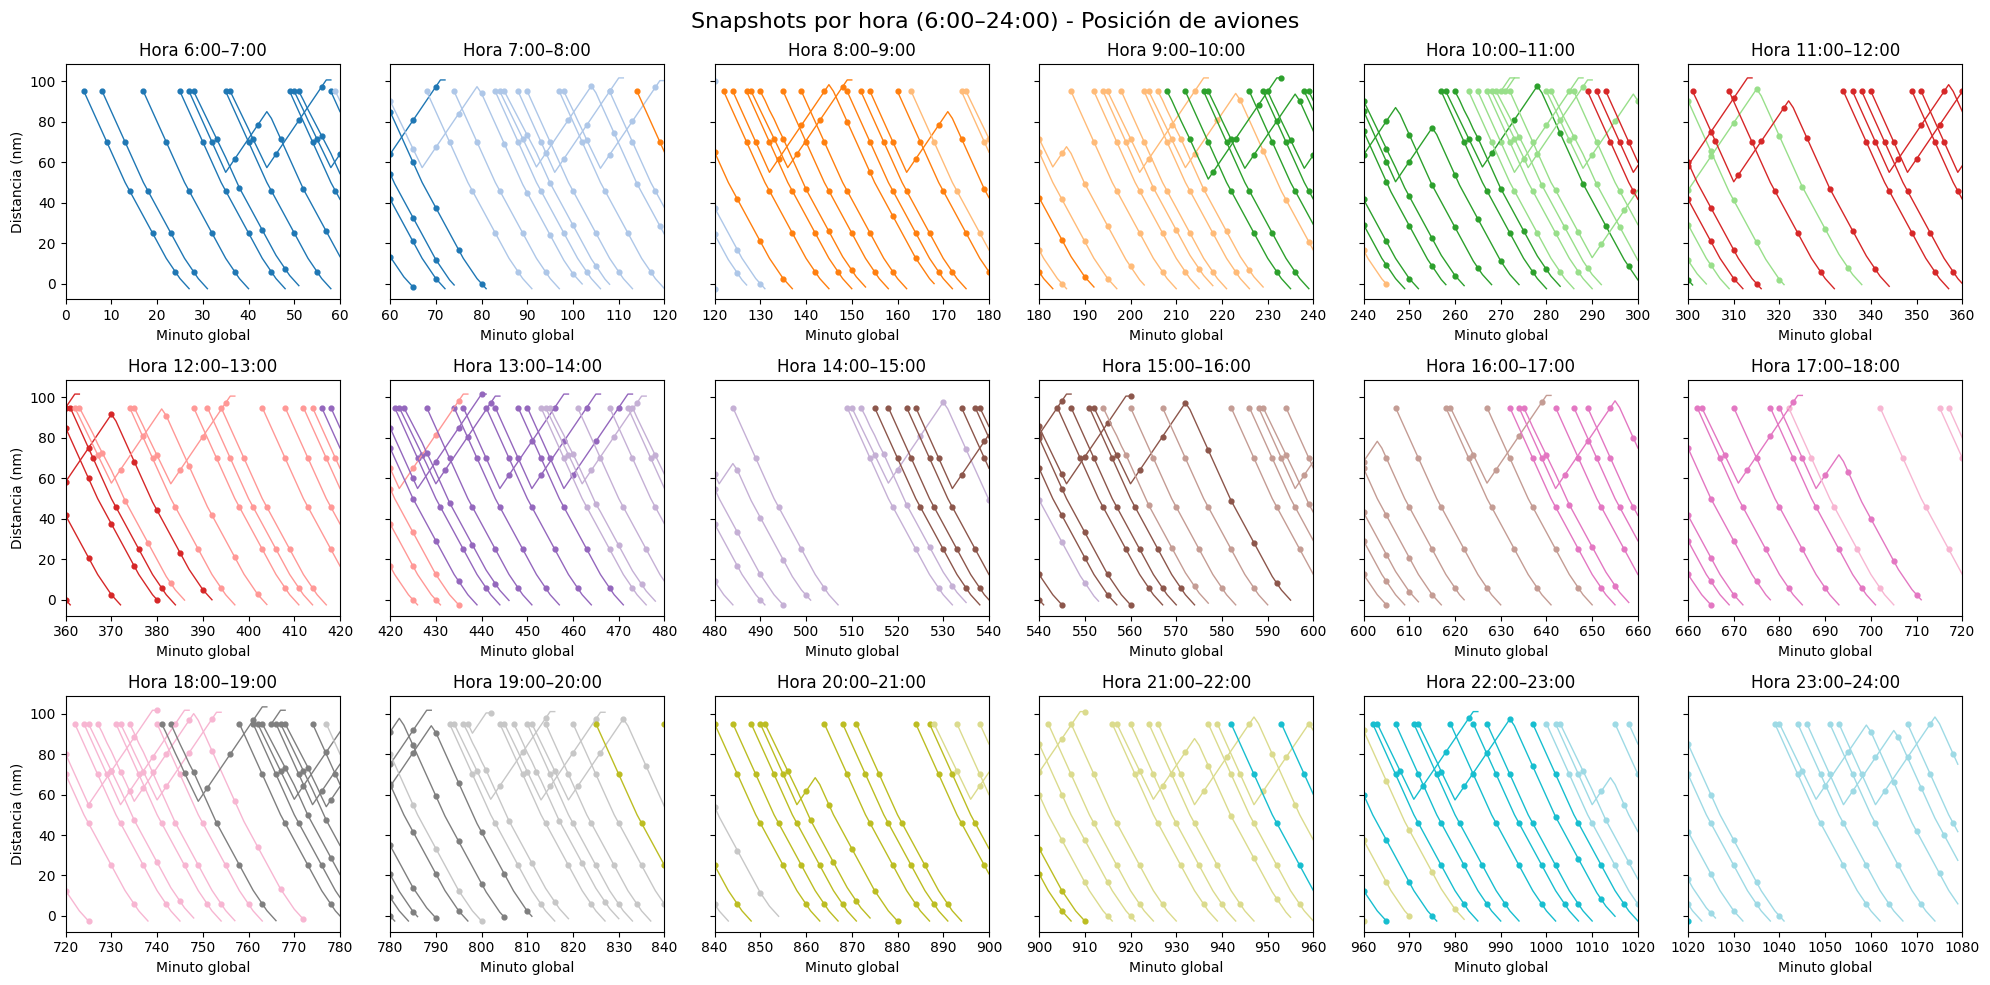

In [ ]:
## POPUESTA 2. 
# una copia del codigo de la simulación, modificando solamente la variable MIN_SEPARACION
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ======================
# Parámetros globales
# ======================
RADAR_DIST = 100
MIN_SEPARACION = 2 #modificacion
VEL_RETROCESO = 200.0

# ======================
# Funciones auxiliares
# ======================
def vel_maxima_permitida_por_tramo(dist_nm: float) -> int:
    """Velocidad máxima permitida según distancia a AEP."""
    if dist_nm > 50:
        return 300
    elif dist_nm > 15:
        return 250
    elif dist_nm > 5:
        return 200
    else:
        return 150

def velocidad_minima_permitida_por_tramo(distancia):
    """Velocidad mínima permitida según distancia a AEP."""
    if distancia > 50:
        return 250
    elif distancia > 15:
        return 200
    elif distancia > 5:
        return 150
    else:
        return 120

def tiempo_entre_aviones(avion_trasero, avion_delantero):
    """Devuelve la separación temporal (min) entre dos aviones."""
    delta_dist = avion_trasero.distancia - avion_delantero.distancia
    if avion_trasero.velocidad <= 0:
        return float("inf")
    return (delta_dist / avion_trasero.velocidad) * 60

def aterrizaje_libre(dist_inicial, minutos) -> float:
    """Distancia que se cubriría a velocidad máxima en un lapso dado."""
    v_max = vel_maxima_permitida_por_tramo(dist_inicial)
    return (v_max / 60.0) * minutos

def hay_gap_disponible(avion, cola) -> bool:
    """Verifica si el avión puede volver con al menos 10 minutos de separación."""
    pos = avion.distancia
    avance_estimado = aterrizaje_libre(pos, minutos=5)

    for otro in cola:
        if otro.estado in ("APROXIMANDO", "AJUSTANDO"):
            if pos - avance_estimado <= otro.distancia <= pos + avance_estimado:
                return False
    return True


# ======================
# Clase Avión . 
# ======================
class Avion:
    def __init__(self, id_avion, minuto_actual):
        self.id = id_avion
        self.distancia = 100.0
        self.velocidad = 0.0
        self.estado = "APROXIMANDO"
        # Estados posibles: APROXIMANDO | AJUSTANDO | REGRESANDO | REGRESANDO_VIENTO | DESVIADO | ATERRIZADO
        self.tiempo_llegada = minuto_actual
        self.retraso = 0
        self.t_aterrizaje = None

    def __repr__(self):
        return (f" Avión {self.id}\n"
                f" - Distancia: {self.distancia:.1f} mn\n"
                f" - Velocidad: {self.velocidad:.0f} kts\n"
                f" - Estado: {self.estado}")

    def controlar_aproximacion(self, lider=None):
        if lider is None:
            self.estado = "APROXIMANDO"
            self.velocidad = vel_maxima_permitida_por_tramo(self.distancia)
            return

        separacion = tiempo_entre_aviones(self, lider)
        if separacion < MIN_SEPARACION:
            nueva_vel = lider.velocidad - 20
            if nueva_vel < velocidad_minima_permitida_por_tramo(self.distancia):
                self.estado = "REGRESANDO" #solo van a regresar si llegan a un punto en el que disminuyen tanto la velocidad que llegan a 0 (o menos)
                self.velocidad = VEL_RETROCESO
    
            else:
                self.estado = "AJUSTANDO" 
                self.velocidad = nueva_vel
        else:
            self.estado = "APROXIMANDO"
            self.velocidad = vel_maxima_permitida_por_tramo(self.distancia)


# ======================
# Clase Simulador
# ======================
class Simulador:
    def __init__(self, seed=42):
        self.rng = np.random.default_rng(seed)
        self.aviones: dict[int, Avion] = {}
        self.historial = []
        self.finalizados: List[Avion] = []

    def generar_nuevo_avion(self, minuto: int, next_id: int, lam: float) -> int:
        if self.rng.random() < lam:
            avion = Avion(next_id, minuto)
            self.aviones[next_id] = avion
            return next_id + 1
        return next_id

    def actualizar_estados(self, minuto: int):
        activos = [a for a in self.aviones.values() if a.estado not in ("ATERRIZADO", "DESVIADO")]
        activos.sort(key=lambda av: av.distancia)

        for i, avion in enumerate(activos):
            if avion.estado == "REGRESANDO":
                self.controlar_regreso(avion, activos)
            else:
                lider = activos[i-1] if i > 0 and activos[i-1].estado != "REGRESANDO" else None
                avion.controlar_aproximacion(lider)

    def controlar_regreso(self, avion, cola):
        if avion.distancia > RADAR_DIST:
            avion.estado = "DESVIADO"
        elif hay_gap_disponible(avion, cola):
            avion.estado = "APROXIMANDO"

    def mover_aviones(self):
        for avion in self.aviones.values():
            if avion.estado in ("ATERRIZADO", "DESVIADO"):
                continue
            delta = avion.velocidad / 60.0
            if avion.estado == "REGRESANDO":
                avion.distancia += delta
            else:
                avion.distancia -= delta

    def gestionar_finalizados(self, minuto: int, tiempo_ideal=23.4):
        for avion in self.aviones.values():
            if avion.estado in ("ATERRIZADO", "DESVIADO"):
                continue
            if avion.distancia <= 0:
                avion.estado = "ATERRIZADO"
                avion.t_aterrizaje = minuto
                tiempo_real = minuto - avion.tiempo_llegada
                avion.retraso = max(0, tiempo_real - tiempo_ideal)
                self.finalizados.append(avion)

    def guardar_estado(self, minuto: int):
        for avion in self.aviones.values():
            self.historial.append({
                "minuto": minuto,
                "id": avion.id,
                "distancia": avion.distancia,
                "velocidad": avion.velocidad,
                "estado": avion.estado,
            })

    def simular_dia(self, lam: float, minutos=18*60):
        next_id = 1
        for minuto in range(minutos):
            next_id = self.generar_nuevo_avion(minuto, next_id, lam)
            self.actualizar_estados(minuto)
            self.mover_aviones()
            self.gestionar_finalizados(minuto)
            self.guardar_estado(minuto)



# ej7.py (igual al ej1 para poder comparar)
# =========================
# Simulación de un día
# =========================
def correr_un_dia(lam=1/60, seed=42):
    sim = Simulador(seed=seed)
    sim.simular_dia(lam)
    return sim


# =========================
# Monte Carlo de arribos
# =========================
from scipy.stats import binom

def monte_carlo_arribos_binomial(lam=1/60, horas=18, repeticiones=1000):
    rng = np.random.default_rng(42)
    minutos = horas * 60
    p = lam
    mu = minutos * p

    simulados = rng.binomial(minutos, p, size=repeticiones)

    plt.hist(simulados, bins=range(simulados.min(), simulados.max()+2),
             density=True, alpha=0.6, color="skyblue", edgecolor="black",
             label="Simulación")

    x = np.arange(simulados.min(), simulados.max()+1)
    plt.plot(x, binom.pmf(x, minutos, p), "g--", lw=2, label="Binomial exacta")

    plt.axvline(simulados.mean(), color="blue", linestyle="--",
                label=f"Media simulada = {simulados.mean():.2f}")
    plt.axvline(mu, color="red", linestyle=":",
                label=f"Media teórica = {mu:.2f}")

    plt.title("Distribución de arribos en 1000 simulaciones (λ=1/60)")
    plt.xlabel("Número de aviones en 18h")
    plt.ylabel("Frecuencia relativa")
    plt.legend()
    plt.show()


# =========================
# Snapshots por hora
# =========================
def graficar_snapshots(sim, lamda, duracion_horas=18):
    historial = sim.historial
    ids = set(reg["id"] for reg in historial)
    cmap = cm.get_cmap("tab20", len(ids))
    colores = {id_: cmap(i) for i, id_ in enumerate(ids)}

    fig, axes = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
    axes = axes.flatten()

    for h in range(duracion_horas):
        minuto_ini = h * 60
        minuto_fin = (h + 1) * 60
        ax = axes[h]

        for id_ in ids:
            # historial completo del avión
            registros = [r for r in historial if r["id"] == id_]
            if not registros:
                continue

            # cortar el historial en el primer aterrizaje/desvío
            corte_idx = None
            for i, r in enumerate(registros):
                if r["estado"] in ("ATERRIZADO", "DESVIADO"):
                    corte_idx = i
                    break
            if corte_idx is not None:
                registros = registros[:corte_idx+1]

            # ahora filtro solo la hora correspondiente
            registros = [r for r in registros if minuto_ini <= r["minuto"] <= minuto_fin]
            if registros:
                ts = [r["minuto"] for r in registros]
                ds = [r["distancia"] for r in registros]
                color = colores[id_]
                ax.plot(ts, ds, color=color, linewidth=1)
                ax.scatter(ts[::5], ds[::5], c=[color], s=12)

        ax.invert_yaxis()
        ax.set_xlim(minuto_ini, minuto_fin)
        ax.set_title(f"Hora {6+h}:00–{7+h}:00")
        ax.set_xlabel("Minuto global")
        if h % 6 == 0:
            ax.set_ylabel("Distancia (nm)")

    plt.suptitle("Snapshots por hora (6:00–24:00) - Posición de aviones", fontsize=16)
    plt.tight_layout()
    #plt.show()

    # ======================
    # Summary de estados finales
    # ======================
    estados_finales = {"ATERRIZADO": 0, "DESVIADO": 0, "ACTIVO": 0}
    atraso = 0
    for avion in sim.aviones.values():
        if avion.estado == "ATERRIZADO":
            estados_finales["ATERRIZADO"] += 1
            atraso += avion.retraso
        elif avion.estado == "DESVIADO":
            estados_finales["DESVIADO"] += 1
        else:
            estados_finales["ACTIVO"] += 1

    
    atraso_promedio = atraso / estados_finales['ATERRIZADO']
        

    print(f"===== 📊 Resumen de la simulación con lam= {lamda} =====")
    print(f"✈️ Total de aviones: {len(sim.aviones)}")
    print(f"✅ Aterrizados: {estados_finales['ATERRIZADO']}")
    print(f"❌ Desviados: {estados_finales['DESVIADO']}")
    print(f"🕐 Activos al final: {estados_finales['ACTIVO']}")
    print(f"Suma de minutos de atraso de todos los aviones aterrizados en la simulacion: {atraso}")
    print(f" Atraso promedio: {atraso_promedio}")



# =========================
# Main
# =========================
if __name__ == "__main__":
    
    lam = 0.2

    # 1. Simulación base
    sim = correr_un_dia(lam)
    print(f"Total aviones generados: {len(sim.aviones)}")
    aterrizados = [a for a in sim.aviones.values() if a.estado == "ATERRIZADO"]
    print(f"Aterrizados: {len(aterrizados)}")

    # 2. Monte Carlo
    monte_carlo_arribos_binomial(lam, repeticiones=1000)

    # 3. Graficar snapshots
    graficar_snapshots(sim, lam)
    



Usamos lamda=0.2 --> un avión cada 5 minutos, en promedio. Este valor nos permite evaluar el efecto de nuestra propuesta ya que es probable que haya aviones a menos de 4 min, y a menos de 2 min entre sí. 

Se evaluó la política de **reducir la distancia temporal mínima entre aviones en la cola de aterrizaje**, pasando de 4 minutos a 2 minutos para aviones no hiperpesados, siguiendo las recomendaciones de seguridad de la FAA. Esta política tiene la ventaja de ser **simple de ejecutar en tiempo real**, ya que los pilotos o controladores solo necesitan conocer la distancia temporal actual con respecto al avión de adelante.

---

#### Resultados de la simulación (λ = 0.2)

| Métrica | Original (4 min) | Distancia mínima 2 min |
|---------|-----------------|----------------------|
| Total de aviones | 230 | 230 |
| Aterrizados | 144 | 190  |
| Desviados a Montevideo | 84 | 36  |
| Activos al final | 2 | 4 |
| Suma de minutos de atraso | 443 | 562.8 |
| Atraso promedio por avión | 3.08 | 2.96  |

**Interpretación:**  
- La política permitió que **más aviones aterrizaran** y redujo significativamente los **desvíos a Montevideo**.  
- El **atraso promedio por avión aterrizado disminuyó ligeramente**, indicando que la eficiencia del flujo de aterrizajes mejoró.  


#### Conclusión y limitaciones de la propuesta
Reducir la distancia mínima entre aviones a 2 minutos demuestra ser una política **efectiva y segura**, que mejora la performance del aeropuerto en términos de **reducción de desvíos y optimización de aterrizajes** sin requerir reglas complejas ni simulaciones en tiempo real. 

Sin embargo, con lamda = 0.2, es muy probable que dos aviones aterricen con menos de 4 minutos de distancia temporal y el aeropuerto podría no querer aplicar esta reducción permanente: por más que no implique un riesgo de seguridad, puede interferir con el flujo de operación del aeropuerto y no dar tiempo a despegues. 

---
